In [2]:
import findspark

findspark.init()

from pyspark.sql import SparkSession

try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("Spark Config - PostgreSQL") \
    .config("spark.jars", "jars/postgresql-42.6.0.jar") \
    .getOrCreate()

print(spark.sparkContext._conf.get("spark.jars"))

jars/postgresql-42.6.0.jar


In [ ]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
load_dotenv()

host = os.environ.get('POSTGRESQL_HOST')
port = os.environ.get('POSTGRESQL_PORT')
database = os.environ.get('POSTGRESQL_DATABASE')
username = os.environ.get('POSTGRESQL_USER')
password = os.environ.get('POSTGRESQL_PASSWORD')

In [4]:
customers = pd.read_excel('data/coffee_data.xlsx', sheet_name='customers')
customers.head()

,Customer ID,Customer Name,Email,Phone Number,Address Line 1,City,Country,Postcode,Loyalty Card
0,17670-51384-MA,Aloisia Allner,aallner0@lulu.com,+1 (862) 817-0124,57999 Pepper Wood Alley,Paterson,United States,7505,Yes
1,73342-18763-UW,Piotr Bote,pbote1@yelp.com,+353 (913) 396-4653,2112 Ridgeway Hill,Crumlin,Ireland,D6W,No
2,21125-22134-PX,Jami Redholes,jredholes2@tmall.com,+1 (210) 986-6806,5214 Bartillon Park,San Antonio,United States,78205,Yes
3,71253-00052-RN,Dene Azema,dazema3@facebook.com,+1 (217) 418-0714,27 Maywood Place,Springfield,United States,62711,Yes
4,23806-46781-OU,Christoffer O' Shea,NaN,+353 (698) 362-9201,38980 Manitowish Junction,Cill Airne,Ireland,N41,No


In [5]:
db_url = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(db_url)

for i, table in enumerate(['customers', 'orders', 'products']):
    df = pd.read_excel(f'data/coffee_data.xlsx', sheet_name=table)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.to_sql(table, engine, if_exists='replace', index=False)

engine.dispose()

In [6]:
for table_name in ['customers', 'orders', 'products']:
    big_table_df = spark.read \
        .format("jdbc") \
        .option("driver", "org.postgresql.Driver") \
        .option("url", f"jdbc:postgresql://{host}:{port}/{database}") \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password) \
        .load()
    
    big_table_df.createOrReplaceTempView(table_name)

In [7]:
all_data = spark.sql("""
    select
        *
    from orders o
    join customers c
        on o.customer_id = c.customer_id
    join products p
        on o.product_id = p.product_id
""")

all_data.createOrReplaceTempView('all_data')
all_data.toPandas().columns

Index(['order_id', 'order_date', 'customer_id', 'product_id', 'quantity',
       'customer_id', 'customer_name', 'email', 'phone_number',
       'address_line_1', 'city', 'country', 'postcode', 'loyalty_card',
       'product_id', 'coffee_type', 'roast_type', 'size', 'unit_price',
       'price_per_100g', 'profit'],
      dtype='object')

In [8]:
profit_data = spark.sql(
"""
select
	o.order_id,
	extract (year from o.order_date) as order_year,
	extract (month from o.order_date) as order_month,
	extract (day from o.order_date) as order_day,
	pc.coffee_type,
	pc.roast_type,
	pc.size,
	pc.unit_price,
	pc.profit,
	o.quantity,
	o.quantity * pc.unit_price as total_price,
	o.quantity * pc.profit as total_profit
from orders o
join (
	select
		p.product_id,
		p.coffee_type,
		p.roast_type,
		p.size,
		p.unit_price,
		p.profit
	from products as p
) as pc
	on o.product_id = pc.product_id 
""")

profit_data.createOrReplaceTempView('profit_data')
profit_data.show()

+-------------+----------+-----------+---------+-----------+----------+----+----------+-------+--------+-----------+------------+
|     order_id|order_year|order_month|order_day|coffee_type|roast_type|size|unit_price| profit|quantity|total_price|total_profit|
+-------------+----------+-----------+---------+-----------+----------+----+----------+-------+--------+-----------+------------+
|GUG-45603-775|      2022|          2|        6|        Lib|         L| 0.2|     4.755|0.61815|       5|     23.775|     3.09075|
|JGZ-16947-591|      2021|          2|        2|        Lib|         L| 0.2|     4.755|0.61815|       6|      28.53|      3.7089|
|RAU-17060-674|      2020|          6|       26|        Lib|         L| 0.2|     4.755|0.61815|       1|      4.755|     0.61815|
|OJL-96844-459|      2020|          5|        3|        Lib|         L| 0.2|     4.755|0.61815|       5|     23.775|     3.09075|
|KHZ-26264-253|      2021|          7|       20|        Lib|         L| 0.2|     4.755|0.6

In [9]:
date_profit_data = spark.sql(
"""
    select
        order_year,
        order_month,
        round (sum(total_price), 2) as price,
        round (sum(total_profit), 2) as profit
    from profit_data
    group by order_year, order_month
    order by order_year desc, order_month desc
""")
date_profit_data.show()
date_profit_df = date_profit_data.toPandas()

+----------+-----------+-------+------+
|order_year|order_month|  price|profit|
+----------+-----------+-------+------+
|      2022|          8| 244.24|  21.3|
|      2022|          7| 906.73| 93.13|
|      2022|          6|1155.39|107.93|
|      2022|          5|1002.37| 97.02|
|      2022|          4| 776.45| 73.21|
|      2022|          3| 1315.2|128.39|
|      2022|          2| 393.63| 40.14|
|      2022|          1|1269.42|146.92|
|      2021|         12|1147.98|115.45|
|      2021|         11|1616.18| 172.6|
|      2021|         10| 1400.4|146.94|
|      2021|          9|1643.58|156.33|
|      2021|          8|1075.91|  96.4|
|      2021|          7| 763.11| 73.01|
|      2021|          6| 864.53| 86.27|
|      2021|          5| 907.69| 86.86|
|      2021|          4|1005.59|114.35|
|      2021|          3|1544.64|156.99|
|      2021|          2| 958.83| 99.64|
|      2021|          1| 837.69| 84.56|
+----------+-----------+-------+------+
only showing top 20 rows



In [10]:
date_profit_df.head()

,order_year,order_month,price,profit
0,2022,8,244.24,21.30
1,2022,7,906.73,93.13
2,2022,6,1155.39,107.93
3,2022,5,1002.37,97.02
4,2022,4,776.45,73.21


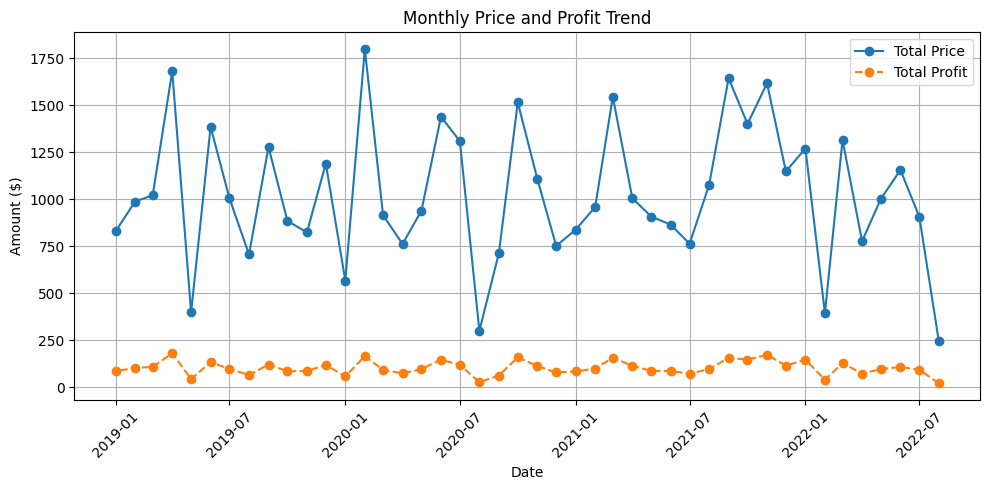

In [11]:
date_profit_df['date'] = pd.to_datetime(date_profit_df['order_year'].astype(str) + '-' + date_profit_df['order_month'].astype(str) + '-01')

plt.figure(figsize=(10, 5))
plt.plot(date_profit_df['date'], date_profit_df['price'], label='Total Price', marker='o')
plt.plot(date_profit_df['date'], date_profit_df['profit'], label='Total Profit', marker='o', linestyle='--')
plt.title('Monthly Price and Profit Trend')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
coffee_type_profit_data = spark.sql(
"""
    select
        coffee_type,
        roast_type,
        -- profit_data.size,
        round (sum(total_price), 2) as price,
        round (sum(total_profit), 2) as profit
    from profit_data
    group by 
        coffee_type,
        roast_type
        -- profit_data.size
"""
)
coffee_type_profit_data.show()
coffee_type_profit_data.createOrReplaceGlobalTempView('coffee_type_profit_data')
coffee_type_profit_df = coffee_type_profit_data.toPandas()

+-----------+----------+-------+------+
|coffee_type|roast_type|  price|profit|
+-----------+----------+-------+------+
|        Rob|         L|3759.47|225.57|
|        Rob|         M|2637.75|158.26|
|        Lib|         D|4096.08|532.49|
|        Ara|         D|3047.69|274.29|
|        Rob|         D|2608.03|156.48|
|        Ara|         M|4488.75|403.99|
|        Exc|         L|4796.55|527.62|
|        Exc|         M|4082.38|449.06|
|        Lib|         L|4566.39|593.63|
|        Exc|         D|3427.51|377.03|
|        Lib|         M|3391.61|440.91|
|        Ara|         L|4232.06|380.89|
+-----------+----------+-------+------+



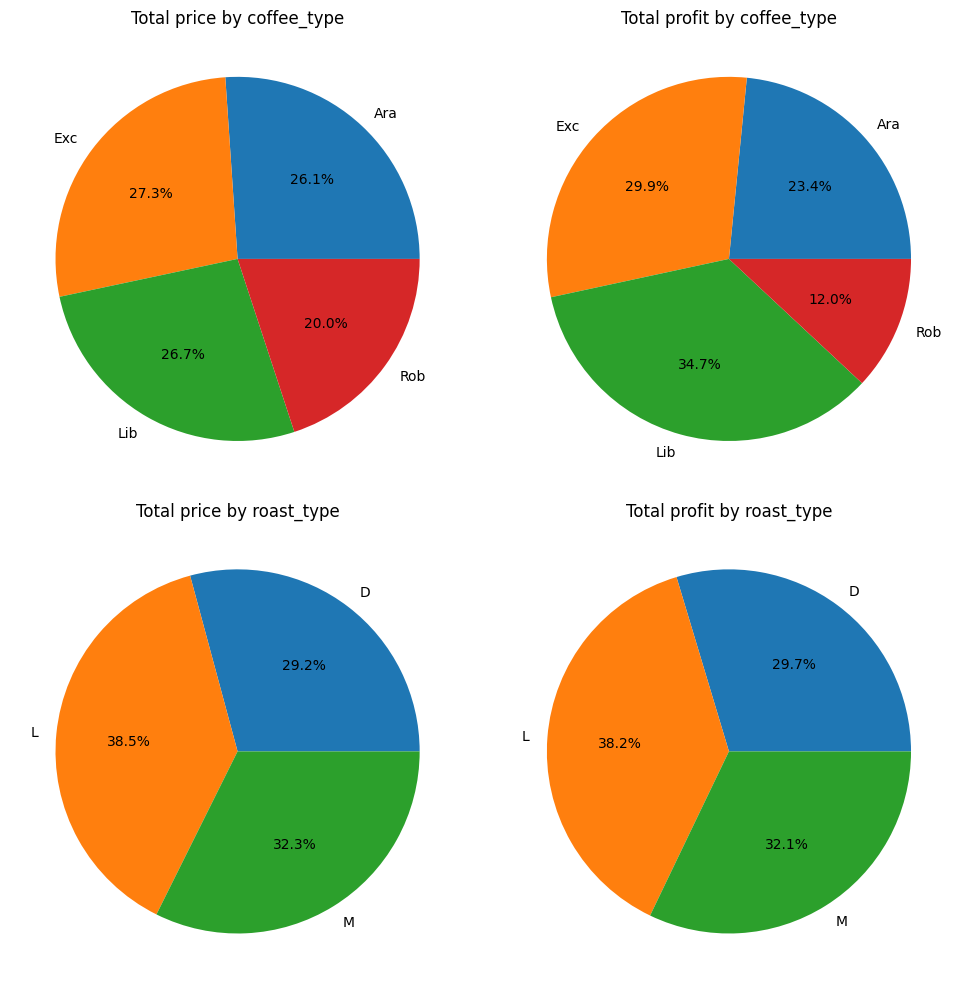

In [13]:
crit_cols = ['coffee_type', 'roast_type']
targ_cols = ['price', 'profit']

plt.figure(figsize=(10, 10))
for x, crit_col in enumerate(crit_cols):
    for y, targ_col in enumerate(targ_cols):
        data = coffee_type_profit_df.groupby(by=crit_col)[targ_col].sum()
        labels = data.index
        plt.subplot(2, 2, x * 2 + y + 1)
        plt.pie(x=data, labels=labels, autopct='%1.1f%%')
        plt.title(f"Total {targ_col} by {crit_col}")
plt.tight_layout()
plt.show()


In [14]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "notebook_connected"

In [15]:
fig = px.sunburst(
    coffee_type_profit_df,
    path=['coffee_type', 'roast_type'],
    values='price',
    color='profit',
    color_continuous_scale='RdBu',
    title='Sunburst: Coffee Type → Roast Type (Size=Price, Color=Profit)',
    hover_data={'price': True, 'profit': True}  
)

fig.show()


In [16]:
fig = px.treemap(
    coffee_type_profit_df,
    path=['coffee_type', 'roast_type'],  
    values='price',                      
    color='profit',                      
    color_continuous_scale='RdBu',
    title='Treemap: Coffee Type → Roast Type (Size = Price, Color = Profit)',
    hover_data={'price': True, 'profit': True}  
)

fig.show()


In [17]:
customer_profit_data = spark.sql(
"""
    select
        o.order_id,
        extract (year from o.order_date) as order_year,
        extract (month from o.order_date) as order_month,
        extract (day from o.order_date) as order_day,
        cc.customer_name,
        cc.country,
        cc.loyalty_card,
        o.quantity * pc.unit_price as total_price,
        o.quantity * pc.profit as total_profit
    from orders o
    join (
        select 
            c.customer_id,
            c.customer_name,
            c.country,
            c.loyalty_card
        from customers c
    ) as cc
        on o.customer_id = cc.customer_id
    join (
        select
            pc.product_id,
            pc.unit_price,
            pc.profit
        from products pc
    ) as pc
        on o.product_id = pc.product_id
"""
)
customer_profit_data.createOrReplaceTempView('customer_profit_data')
customer_profit_data.show()
customer_profit_df = customer_profit_data.toPandas()

+-------------+----------+-----------+---------+------------------+-------------+------------+------------------+-------------------+
|     order_id|order_year|order_month|order_day|     customer_name|      country|loyalty_card|       total_price|       total_profit|
+-------------+----------+-----------+---------+------------------+-------------+------------+------------------+-------------------+
|KYS-27063-603|      2019|          6|       30|      Shannon List|United States|          No|136.61999999999998| 15.028199999999998|
|VAJ-44572-469|      2020|         10|       27|    Delmar Beasant|      Ireland|         Yes|21.509999999999998| 1.2905999999999997|
|VIO-27668-766|      2019|         12|       15|     Dick Drinkall|United States|         Yes|20.584999999999997| 1.2350999999999999|
|ULU-07744-724|      2020|          3|       26|      Layne Imason|United States|         Yes|43.650000000000006|             5.6745|
|RZC-75150-413|      2020|          3|       25|   Roxie Deaco

In [18]:
customer_name_profit_data = spark.sql(
"""
    select
    	customer_name,
        round(sum(total_price), 2) as price,
        round(sum(total_profit), 2) as profit
    from customer_profit_data
    group by customer_name
"""
)
customer_name_profit_data.show()
customer_name_profit_df = customer_name_profit_data.toPandas()

+--------------------+------+------+
|       customer_name| price|profit|
+--------------------+------+------+
|  Minny Chamberlayne| 63.25|  6.96|
|    Tuckie Mathonnet|153.53|  9.21|
|        Miran Doidge| 41.25|  4.54|
| Gregorius Trengrove|148.92|  13.4|
|      Silvio Iorizzi|  8.73|  1.13|
| Elizabet Aizikowitz| 35.64|  3.92|
|    Gallard Gatheral| 23.78|  3.09|
|         Dottie Tift| 21.87|  2.41|
|       Lenka Rushmer|  77.7|  6.99|
|Rudiger Di Bartol...|  7.77|   0.7|
|      Julius Mccaull| 41.25|  4.54|
|     Fernando Sulman|  35.8|  2.15|
|   Kimberli Mustchin| 44.55|   4.9|
|     Ketty Bromehead|119.14| 15.49|
|       Willy Pummery| 28.53|  3.71|
|       Xenos Gibbons| 38.85|   3.5|
|       Darrin Tingly|111.78|  12.3|
|     Stacy Pickworth| 44.75|  2.68|
|        Emalee Rolin| 22.28|  2.45|
|     Roxie Deaconson| 36.45|  4.01|
+--------------------+------+------+
only showing top 20 rows



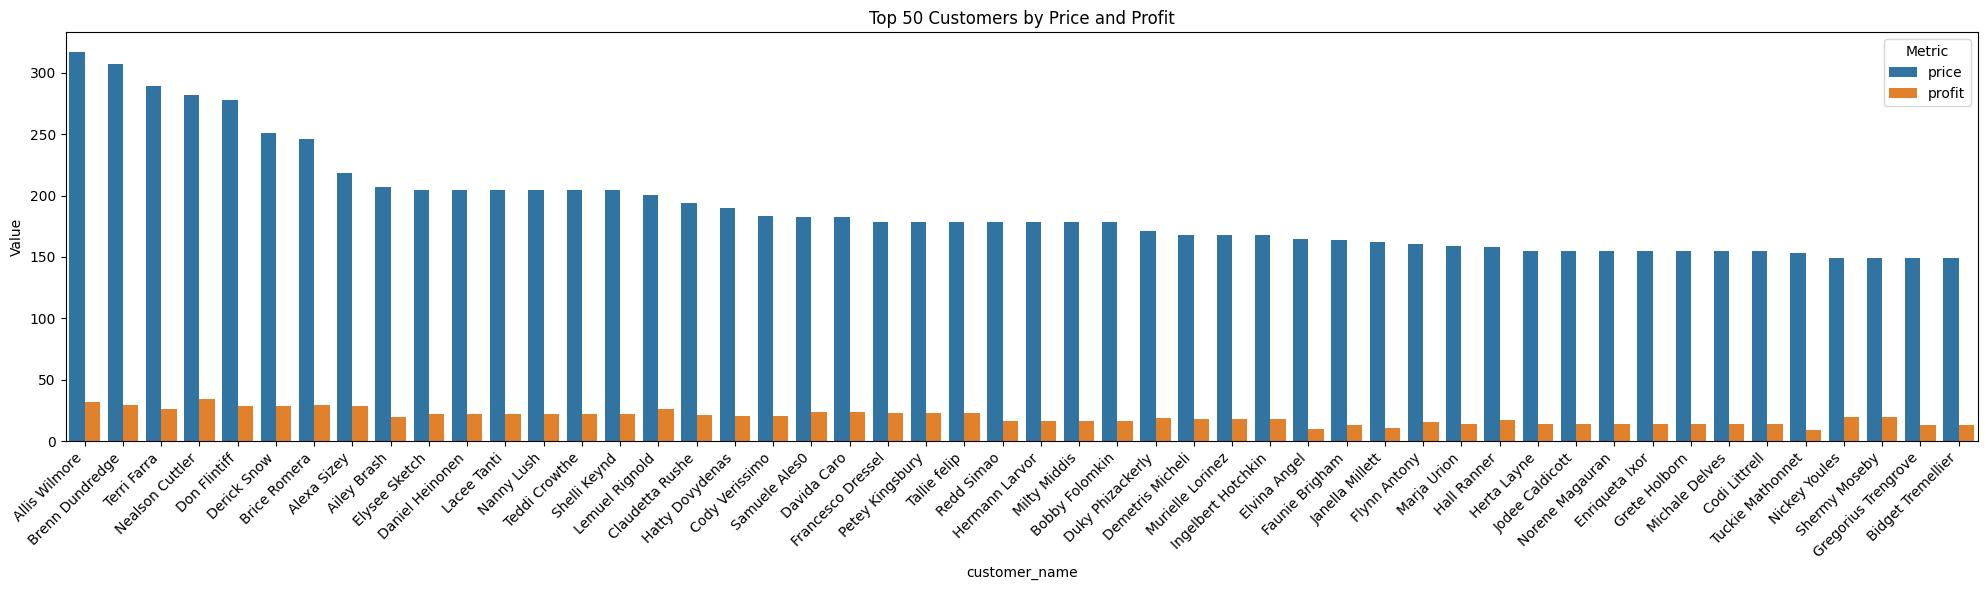

In [19]:
top_50_customer_name_profit_df = customer_name_profit_df.sort_values(by=['price', 'profit'], ascending=False).head(50)

melted_df = top_50_customer_name_profit_df.melt(
    id_vars='customer_name', 
    value_vars=['price', 'profit'], 
    var_name='Metric', 
    value_name='Value'
)

plt.figure(figsize=(20, 6))
sns.barplot(data=melted_df, x='customer_name', y='Value', hue='Metric')

plt.title('Top 50 Customers by Price and Profit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
# try:
#     spark.stop()
# except:
#     pass